#### Introduction
This project's dataset was sourced from [kaggle](https://www.kaggle.com/datasets/xiaomengsun/car-insurance-claim-data). 

It includes approximately 8,000 records of car insurance policyholders, with features such as age, income, gender, claim history, and more.

The dataset contains two target variables:

- Whether a claim has occurred.
- The total cost of the claim, given that a claim has been made.

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

### 1. Basic Cleaning and Creating Train/Test Split
#### 1.1 Reading in the data and inspection

In [2]:
raw_data = pd.read_csv("./data/car_insurance_claim.csv")

In [3]:
pd.set_option("display.max_columns", None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


#### 1.2 Basic Data Cleaning

In [4]:
# create a new copy of the data
data_df = raw_data.copy()

In [5]:
data_df.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CLM_AMT', 'CAR_AGE',
       'CLAIM_FLAG', 'URBANICITY'],
      dtype='object')

In [6]:
# Define updated column names
col_names = {
    "KIDSDRIV" : "num_young_drivers",
    "BIRTH" : "date_of_birth",
    "AGE": "age", 
    "HOMEKIDS" : "num_of_children",
    "YOJ" : "years_job_held_for",
    "INCOME" : "income",
    "PARENT1" : "single_parent",
    "HOME_VAL" : "value_of_home",
    "MSTATUS" : "married",
    "GENDER" : "gender",
    "EDUCATION" : "highest_education",
    "OCCUPATION" : "occupation",
    "TRAVTIME" : "commute_dist",
    "CAR_USE" : "type_of_use",
    "BLUEBOOK" : "vehicle_value",
    "TIF" : "policy_tenure",
    "CAR_TYPE" : "vehicle_type",
    "RED_CAR" : "red_vehicle",
    "OLDCLAIM"  : "5_year_total_claims_value",
    "CLM_FREQ" : "5_year_num_of_claims",
    "REVOKED" : "licence_revoked",
    "MVR_PTS" : "license_points",
    "CLM_AMT" : "new_claim_value",
    "CAR_AGE" : "vehicle_age",
    "CLAIM_FLAG" : "is_claim",
    "URBANICITY" : "address_type"
}

In [7]:
# update col names
data_df.rename(columns=col_names, inplace=True)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [9]:
# Check for duplicate records
data_df.duplicated().sum()

1

In [10]:
# drop duplicate
data_df.drop_duplicates(inplace=True)

In [11]:
# Define currency cols
currency_cols = ["income", "value_of_home", "vehicle_value", "5_year_total_claims_value", "new_claim_value"]

# create function to remove $ and ","
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace("[\\$,]", "", regex=True).astype("Int64")
    return data

data_df = format_currency_cols(data_df, currency_cols)

In [12]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,z_No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,z_No,M,z_High School,z_Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,z_No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,z_F,z_High School,Clerical,5,Private,4010,4,z_SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,z_Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [13]:
# Define cols that have prefix
z_prefix_cols = ["married", "gender", "highest_education", "occupation", "vehicle_type", "address_type"]

# Create functions to remove "z" prefix

def remove_prefix(data, cols):
    for col in cols:
        data[cols] = data[cols].replace("[z_]", "", regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

In [14]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [15]:
# Drop the features we don't need
data_df.drop(["ID", "date_of_birth"], axis=1, inplace=True)

In [16]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [17]:
# data_df.to_csv("./data/data_df.csv")

In [18]:
# data_df = pd.read_csv("./data/data_df.csv", index_col=0)

In [19]:
# data_df.head()

#### 1.3 Create Train/Test Split

In [20]:
# Check there are no non-zero values for "new_claim_value" where "is_claim" = 1
mask = (data_df["new_claim_value"] > 0) & (data_df["is_claim"] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

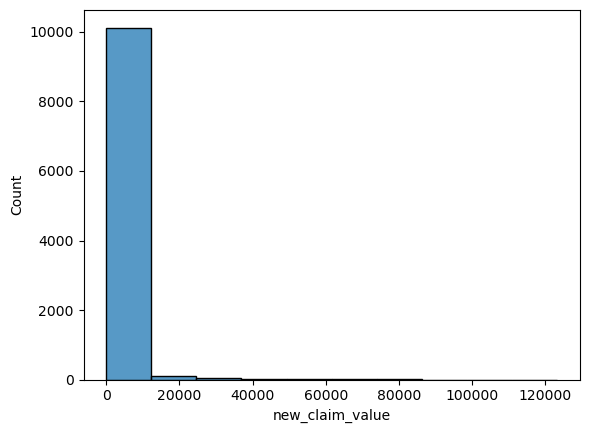

In [23]:
# Create histplot for new claim value
sns.histplot(data_df["new_claim_value"], bins=10)

In [24]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

In [25]:
data_df["claim_value_cat"].value_counts()

claim_value_cat
1     9316
2      789
4       48
3       45
5       27
11      19
6       18
7       14
8       10
9        8
10       7
Name: count, dtype: int64

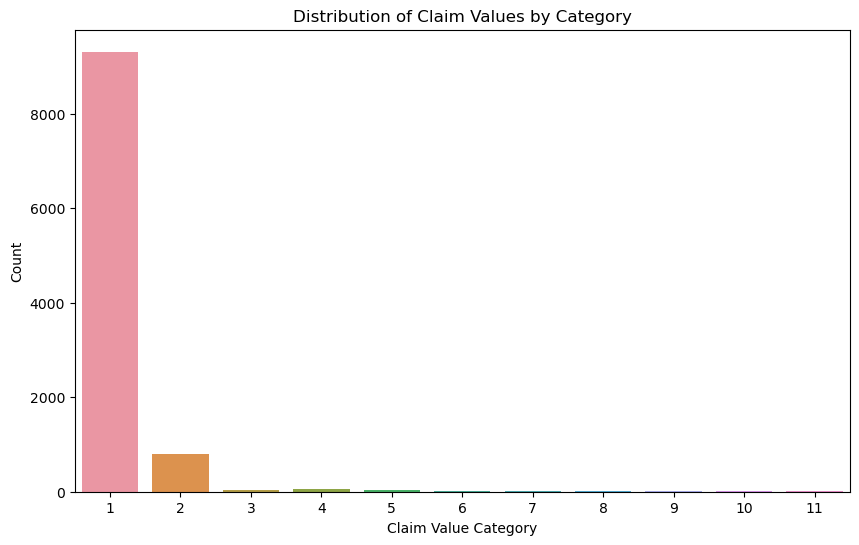

In [26]:
# Get the count of each bin
bin_counts = data_df['claim_value_cat'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values)
plt.xlabel("Claim Value Category")
plt.ylabel("Count")
plt.title("Distribution of Claim Values by Category")
plt.show()

In [27]:
# Create clean copy of training data
X = data_df.copy()
y = data_df["is_claim"]

# Drop the target feature
X.drop(["new_claim_value","is_claim"], axis=1, inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X["claim_value_cat"])

In [28]:
train_ratio = round((y_train.sum()/len(y_train))*100, 2)
test_ratio = round((y_test.sum()/len(y_test) * 100), 2)

print(f"Train positive class ratio: {train_ratio}%")
print(f"Test positive class ratio: {test_ratio}%")

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


In [29]:
for set_ in (X_train, X_test):
    set_.drop(columns=["claim_value_cat"], inplace=True)

#### 2. Exploratory Data Analysis (EDA)
##### 2.1 Preparation

In [30]:
# Create new copy of X_train for analysis
eda_test_data = X_train.copy()
# eda_test_data = data_df.copy()
eda_test_data["is_claim"] = y_train

In [31]:
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,No,0,No,F,<High School,Blue Collar,40,Private,7200,10,SUV,no,0,0,No,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,No,109835,Yes,F,<High School,Blue Collar,24,Private,6530,4,Sports Car,no,0,0,No,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,Yes,174139,No,M,<High School,Clerical,39,Private,1500,4,Minivan,no,5419,1,No,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,Yes,202178,No,F,Bachelors,Professional,18,Private,22260,1,Minivan,no,5290,1,No,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,No,312887,Yes,M,High School,Professional,25,Commercial,5400,1,Pickup,no,0,0,No,1,5.0,Highly Urban/ Urban,0


In [32]:
# Define binary cols
binary_cols = ["single_parent", "married", "gender", "red_vehicle", "licence_revoked"]

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
}

# Define funciton to binaries feature
def binary_feature(data, binary_cols, mapping):
    for col in binary_cols:
        data[col] = data[col].map(mapping)
    return data

# call funciton

eda_test_data = binary_feature(eda_test_data, binary_cols, mapping)

In [33]:
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


##### 2.2 Correlation Matrix

In [34]:
eda_test_data.corr(numeric_only=True).sort_values(by="is_claim", ascending=False)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
is_claim,0.109085,-0.107146,0.128697,-0.053815,-0.147085,0.154323,-0.193881,-0.132326,-0.021205,0.044019,-0.103979,-0.082839,-0.007045,0.147094,0.224952,0.158972,0.218605,-0.113344,1.000000
5_year_num_of_claims,0.034724,-0.037820,0.038404,-0.026019,-0.044323,0.060335,-0.092703,-0.070880,0.014060,0.006396,-0.034264,-0.015396,0.027464,0.491048,1.000000,0.054301,0.403083,-0.023960,0.224952
license_points,0.052874,-0.079780,0.071365,-0.040719,-0.065223,0.074748,-0.097057,-0.050486,-0.006218,0.006975,-0.053148,-0.032602,0.004845,0.267866,0.403083,0.054818,1.000000,-0.035502,0.218605
licence_revoked,0.040039,-0.045184,0.051109,-0.009085,-0.031050,0.052374,-0.048395,-0.039376,-0.024676,0.002763,-0.028597,-0.029388,-0.018617,0.422329,0.054301,1.000000,0.054818,-0.027414,0.158972
single_parent,0.204141,-0.314111,0.456293,-0.027043,-0.069598,1.000000,-0.248240,-0.476495,-0.061451,-0.016323,-0.042579,0.009828,-0.039510,0.044080,0.060335,0.052374,0.074748,-0.063892,0.154323
5_year_total_claims_value,0.035981,-0.040818,0.049397,-0.005708,-0.049042,0.044080,-0.067330,-0.043098,-0.009735,-0.017241,-0.030692,-0.012395,0.006578,1.000000,0.491048,0.422329,0.267866,-0.031716,0.147094
num_of_children,0.461488,-0.448207,1.000000,0.079570,-0.158150,0.456293,-0.106974,0.037708,-0.114426,-0.000621,-0.109210,0.012882,-0.072370,0.049397,0.038404,0.051109,0.071365,-0.152561,0.128697
num_young_drivers,1.000000,-0.076813,0.461488,0.038082,-0.046508,0.204141,-0.022470,0.037441,-0.041781,0.012918,-0.026245,-0.004106,-0.045062,0.035981,0.034724,0.040039,0.052874,-0.062621,0.109085
commute_dist,0.012918,0.003201,-0.000621,-0.008878,-0.051479,-0.016323,-0.031111,0.007881,-0.007181,1.000000,-0.024179,-0.002833,0.015903,-0.017241,0.006396,0.002763,0.006975,-0.037156,0.044019
red_vehicle,-0.045062,0.028833,-0.072370,0.054180,0.061301,-0.039510,0.027262,-0.018030,0.664545,0.015903,0.028362,-0.010116,1.000000,0.006578,0.027464,-0.018617,0.004845,0.012896,-0.007045


<Axes: >

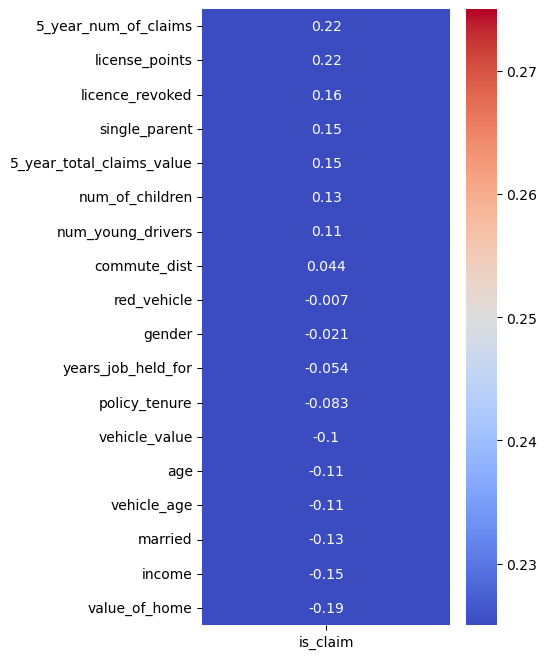

In [35]:
fig, ax = plt.subplots(figsize=(4,8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by="is_claim", ascending=False)
corr_matrix_no_claim = corr_matrix.drop("is_claim")

sns.heatmap(corr_matrix_no_claim[["is_claim"]], cmap="coolwarm", annot=True, vmax=0.25, vmin=0.25)

In [36]:
eda_test_data["single_parent"].value_counts()

single_parent
0    7161
1    1079
Name: count, dtype: int64

#### 3. Data Cleaning and Preprocessing
##### 3.1 Dropping Features
Dropping the "red_vehicle" as this showed next to no correlation with the target variable

In [37]:
X_train_raw = X_train.copy()

X_train_raw.drop("red_vehicle", axis=1, inplace=True)

##### 3.2 Handling Missing Values
The handling of missing values is a very important issue in statistical analysis. The default behavior of the functions

How many are they

In [38]:
# Checking for missing values in each
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

There is a significant number of missing values in our dataset, which we need to address when developing the data pipeline. Given the volume and numerical nature of these missing values, simple imputation methods like median or mean might be too simplistic. Instead, we should use K-Nearest Neighbors (KNN) for a more sophisticated imputation approach.

In [39]:
X_train_raw.isnull().sum().sum()

2418

In [40]:
# initializing the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Numerical Cols
numerical_cols_df = X_train_raw.select_dtypes(include=["number"])
numerical_cols = numerical_cols_df.columns.tolist()

# Categorical Cols
categorical_cols_df = X_train_raw.select_dtypes(include=["object"])
categorical_cols = categorical_cols_df.columns.tolist()

In [41]:
# KNN imputer function
def num_knn_impute(df, cols, imputer):
    df = df[cols]
    df_imputed = pd.DataFrame(imputer.fit_transform(df))
    df_imputed.columns = df.columns
    return df_imputed

# Calling the funciton
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

We can now review some of the records that initially had missing data to see the results of the imputations.

In [42]:
# Numerical cols df
numerical_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)

# Missing values only
missing_data_df = numerical_cols_df[numerical_cols_df.isnull().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [43]:
# Some records after imputation
samples = missing_data_df.index.tolist()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


We can observe that the missing values have been successfully imputed.

For categorical value imputation, we'll use a simple imputer with the 'most_frequent' strategy.

In [44]:
# Simple imputer
simple_imputer = SimpleImputer(strategy="most_frequent")

# categorical features simple imputer function
def simple_imputer_categorical(df, categorical_features, imputer):
    df = df[categorical_features]
    df_imputed = pd.DataFrame(imputer.fit_transform(df))
    df_imputed.columns = df.columns
    return df_imputed

# Calling the function

cat_test_data_imputed = simple_imputer_categorical(X_train_raw, categorical_cols, simple_imputer)

In [45]:
# Checking berfore and after imputation
# Get categorical cols as a df
categorical_cols_df = X_train_raw[categorical_cols].reset_index(drop=True)

# Rows with missing values
missing_cat_data_df = categorical_cols_df[categorical_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,NaN,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,NaN,Commercial,Panel Truck,No,Highly Rural/ Rural


In [46]:
# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,Blue Collar,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,Blue Collar,Commercial,Panel Truck,No,Highly Rural/ Rural


We can now combine the imputed numerical and categorical data to form the complete DataFrame.

In [47]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


In [48]:
# check for missing value again
3# train_imputed_df.info()
train_imputed_df.isna().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

##### 3.4 Categorical Feature Encoding
The categorical feature encoding is a process of converting categorical features into numerical features. 

We now need to determine the best way to encode the categorical features for use with machine learning algorithms. First, let's examine the number of unique values in each categorical feature to decide on the most suitable encoding method for each.

In [49]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

- Single parent has only 2 values, so we can use binary encoding for this feature.
- Married has only 2 values, so we can use binary encoding for this feature.
- Gender has only 2 values, so we can use binary encoding for this feature.
- Highest education has 5 unique values, and these have a rank/order (the level of education). We can
  use ordinal encoding for this feature.
- For occupation, we have 8 differnet values with no ranking or order. We can use one-hot encoding for this feature.
- Type of use has only 2 values, so we can use binary encoding for this feature.
- Vehicle type has 6 different values with no ranking or order. We can use one-hot encoding for this feature.
- Red vehicle has only 2 values, so we can use binary encoding for this feature.
- License revoked has only 2 values, so we can use binary encoding for this feature.
- Address type has only 2 values, so again, we can use binary encoding for this feature.

In [50]:
# Oridinal Features
categorical_cols_ord = ["highest_education"]

# Binanry Feature
categorical_cols_bin = ["single_parent", "married", "gender", "type_of_use", "licence_revoked", "address_type"]

# One-hot features
categorical_cols_onehot = ["occupation", "vehicle_type"]

We need to define the order  of the level of education

In [51]:
education_rank = [["<High School", "High School", "Bachelors", "Masters", "PhD"]]

# ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[categorical_cols_ord])
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = categorical_cols_ord

In [52]:
# binary encoder
bin_encoder = OrdinalEncoder()
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[categorical_cols_bin])
bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = categorical_cols_bin

In [53]:
# one-hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[categorical_cols_onehot])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

In [54]:
# Combine encoded dfs to a single df
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Combining our eincoded features back with the nuermical features to give us our pre-processed data

In [55]:
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Since we've applied one-hot encoding to some features, we will likely encounter the 'dummy variable trap'. This happens when one of the dummy variables becomes redundant, leading to perfect multicollinearity. In other words, knowing the values of all but one feature allows you to perfectly predict the remaining feature. To check for multicollinearity, we can use the Variance Inflation Factor (VIF).

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(dataframe):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the DataFrame.
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame containing the features for which to calculate VIF.
    
    Returns:
    pd.DataFrame: DataFrame with features and their corresponding VIF values.
    """
    # Add a constant column to the DataFrame for the intercept
    dataframe_with_constant = pd.DataFrame(dataframe)
    dataframe_with_constant['constant'] = 1

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe_with_constant.values, i)
                       for i in range(dataframe_with_constant.shape[1] - 1)]
    
    return vif_data

In [57]:
vif_df = calculate_vif(X_train_cleaned)
vif_df

c:\Users\Luee\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,num_young_drivers,1.317458
1,age,1.470704
2,num_of_children,2.083100
3,years_job_held_for,1.437881
4,income,2.633292
5,value_of_home,2.120414
6,commute_dist,1.039162
7,vehicle_value,2.030342
8,policy_tenure,1.005861
9,5_year_total_claims_value,1.680062



We can clearly see that the one-hot encoded features (occupation and vehicle type) exhibit perfect multicollinearity. The simplest way to address this issue is to drop one of the dummy variables from the encoded data. This approach is often referred to as dropping the 'reference category' or 'baseline' category.

In [58]:
X_train_cleaned.drop(["occupation_Blue Collar", "vehicle_type_Minivan"], axis=1, inplace=True)

In [59]:
# Lets check the Variance Inflation Factor
vif_data = calculate_vif(X_train_cleaned)
vif_data

,Feature,VIF
0,num_young_drivers,1.317458
1,age,1.470704
2,num_of_children,2.083100
3,years_job_held_for,1.437881
4,income,2.633292
5,value_of_home,2.120414
6,commute_dist,1.039162
7,vehicle_value,2.030342
8,policy_tenure,1.005861
9,5_year_total_claims_value,1.680062


#### 5. Model Selection

We'll start by using several of the most popular classifiers with default parameters and compare how well they perform to indentify which might be best to proceed with.

In [60]:
# Classifiers to test
clfs = [
    ("Logistic Regression", LogisticRegression(solver="liblinear", max_iter=2000)),
    ("KNN", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    # ("Linear SVM", LinearSVC(random_state=42, max_iter=1000, dual="auto")),
    ("XGBoost", XGBClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42, algorithm="SAMME")),
    ("Gradient Boost", GradientBoostingClassifier(random_state=42)),
    ("Bagging", BaggingClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=0)),
]

We'll use cross-validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.

In [61]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store results dict
results = {}

# Evaluate Each classifier using cross_validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf)
    results[clf_name] = cv_scores
    
cv_scores_df = pd.DataFrame(results)

Plot the results of each test, for each classifier with a boxplot for comparison

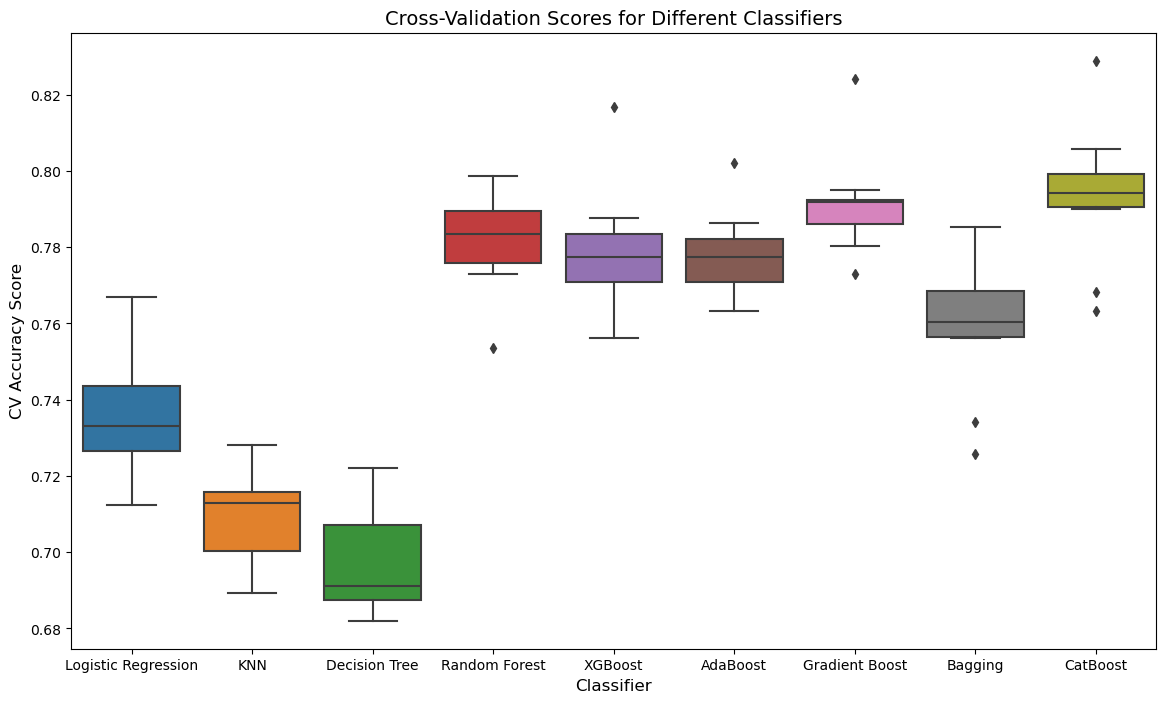

In [62]:
# Plot Scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# add axis lables
ax.set_xlabel("Classifier", fontsize=12)
ax.set_ylabel("CV Accuracy Score", fontsize=12)
ax.set_title("Cross-Validation Scores for Different Classifiers", fontsize=14)
plt.savefig("./data/cross_validation_scores_for_different_classifiers.jpg")

The best performing model was CatBoost, followed by Gradient Boost.

The worst perfoming model was the Descision Tree

Choose to continue with XGBoost model as hyperparameter tuning is much faster

In [63]:
X_train_cleaned.to_pickle("./data/X_train_cleaned.pkl")

In [64]:
X_train_cleaned = pd.read_pickle("./data/X_train_cleaned.pkl")

#### 6. Feature Engineering

Let's take a look at the distributions of our numerical features to see if we could potentially improve the performance of our models by transforming any existing features. First we'll create histograms for each of the numerical features.

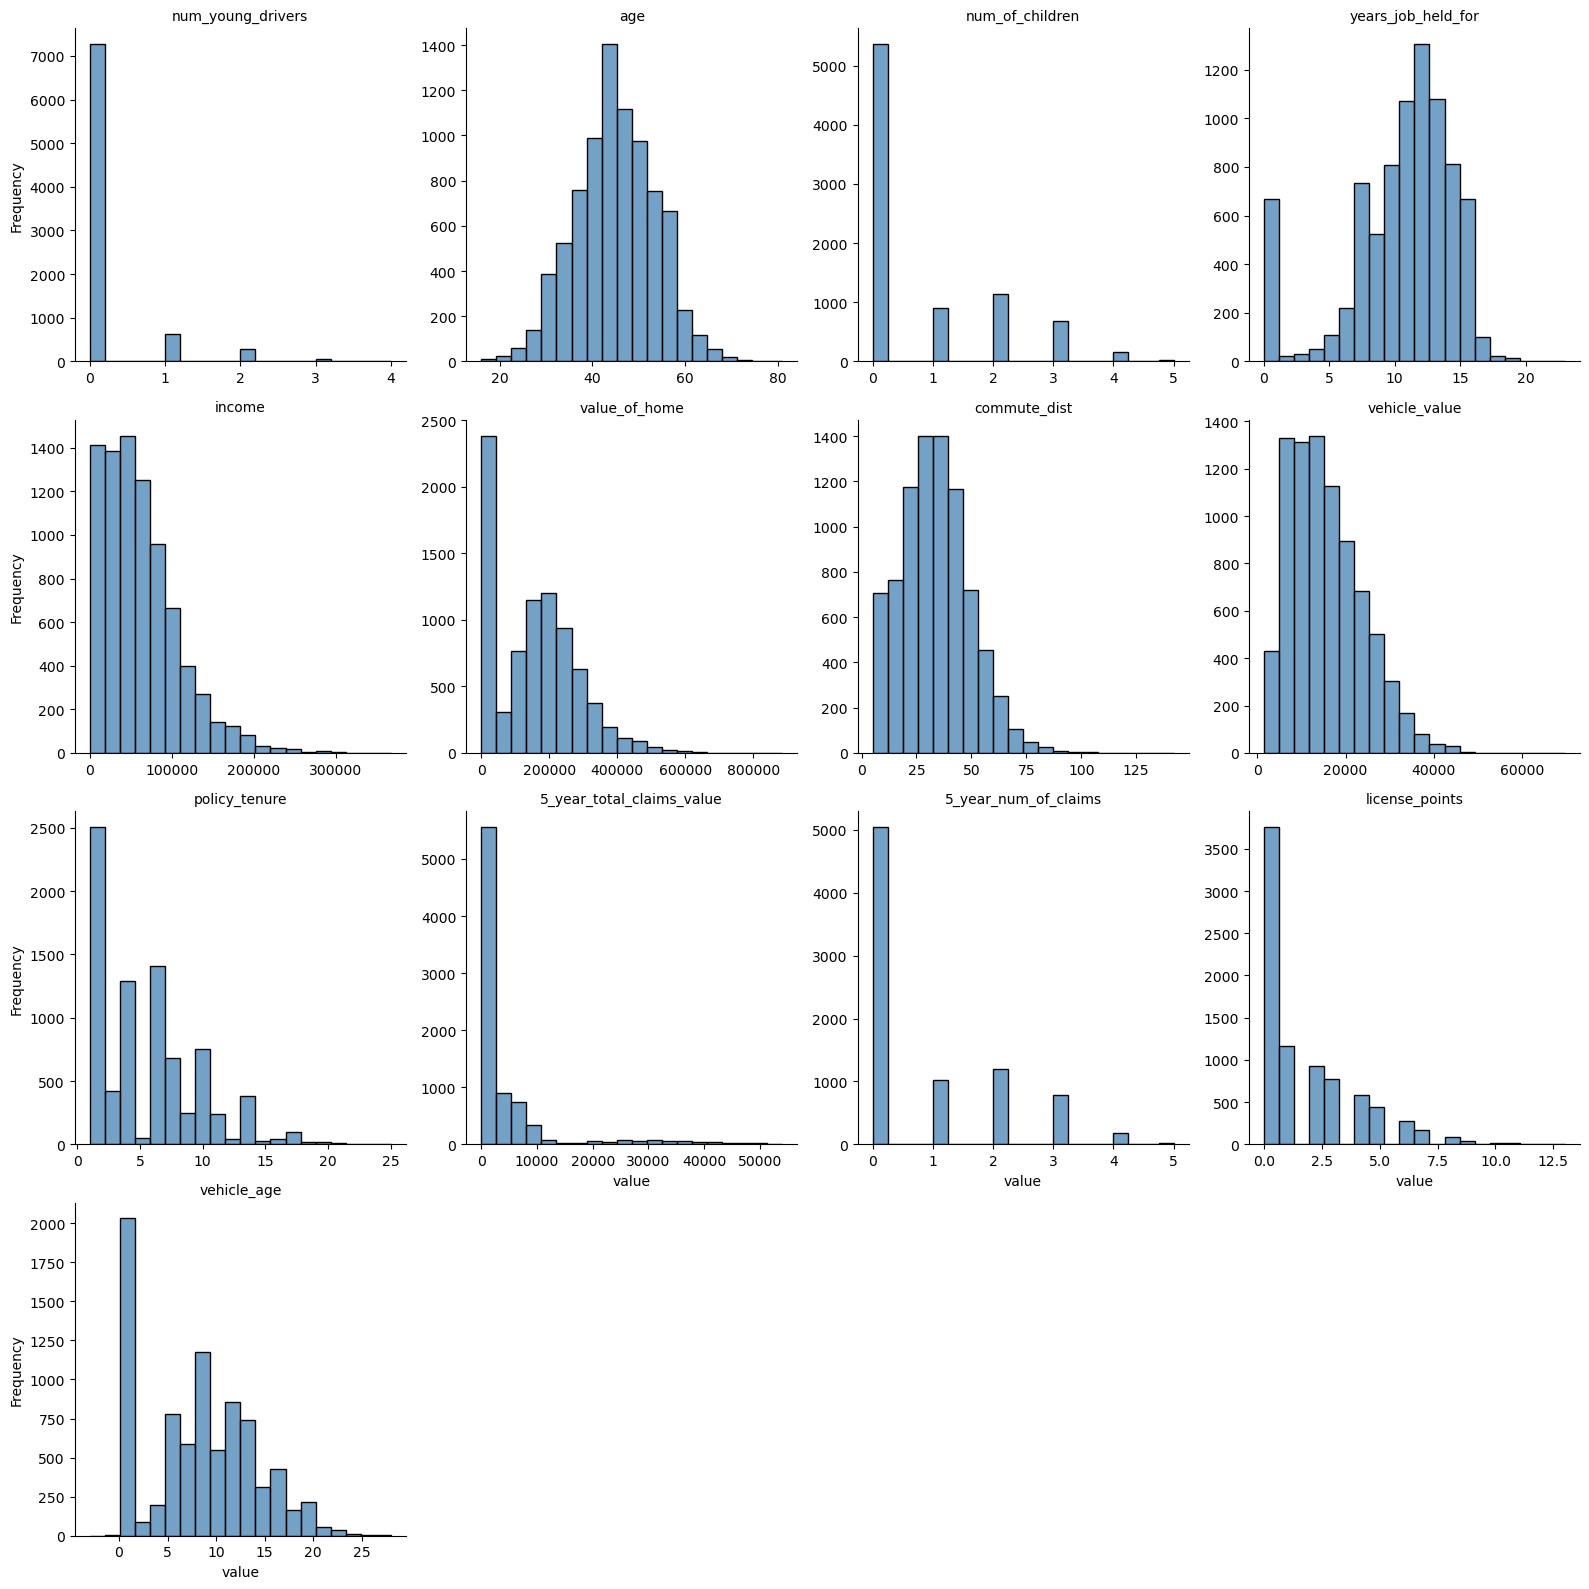

In [65]:
# Melt the DataFrame to Long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name="Column", value_name="Value")

# Create a FaceGrid
g = sns.FacetGrid(melted_X_train, col="Column", col_wrap=4, sharex=False, sharey=False, height=4)

# mapping each sns.histplot to facet
g.map(sns.histplot, "Value", bins=20, color="steelblue")

# adding titles and labels
g.set_axis_labels("value", "Frequency")
g.set_titles(col_template="{col_name}")

plt.tight_layout()
plt.show()

We can see that some of the features have a right skew. We can try to log transform these features to reduce the skew.

In [66]:
# Define features we right skew
skewed_features = ["income", "value_of_home", "commute_dist", "vehicle_value", "policy_tenure", "license_points"]

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        # data[feature] = np.log(data[feature] + 1)
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

We can now look at the distributions again to see if the log transform was effective at reducing the right skews.

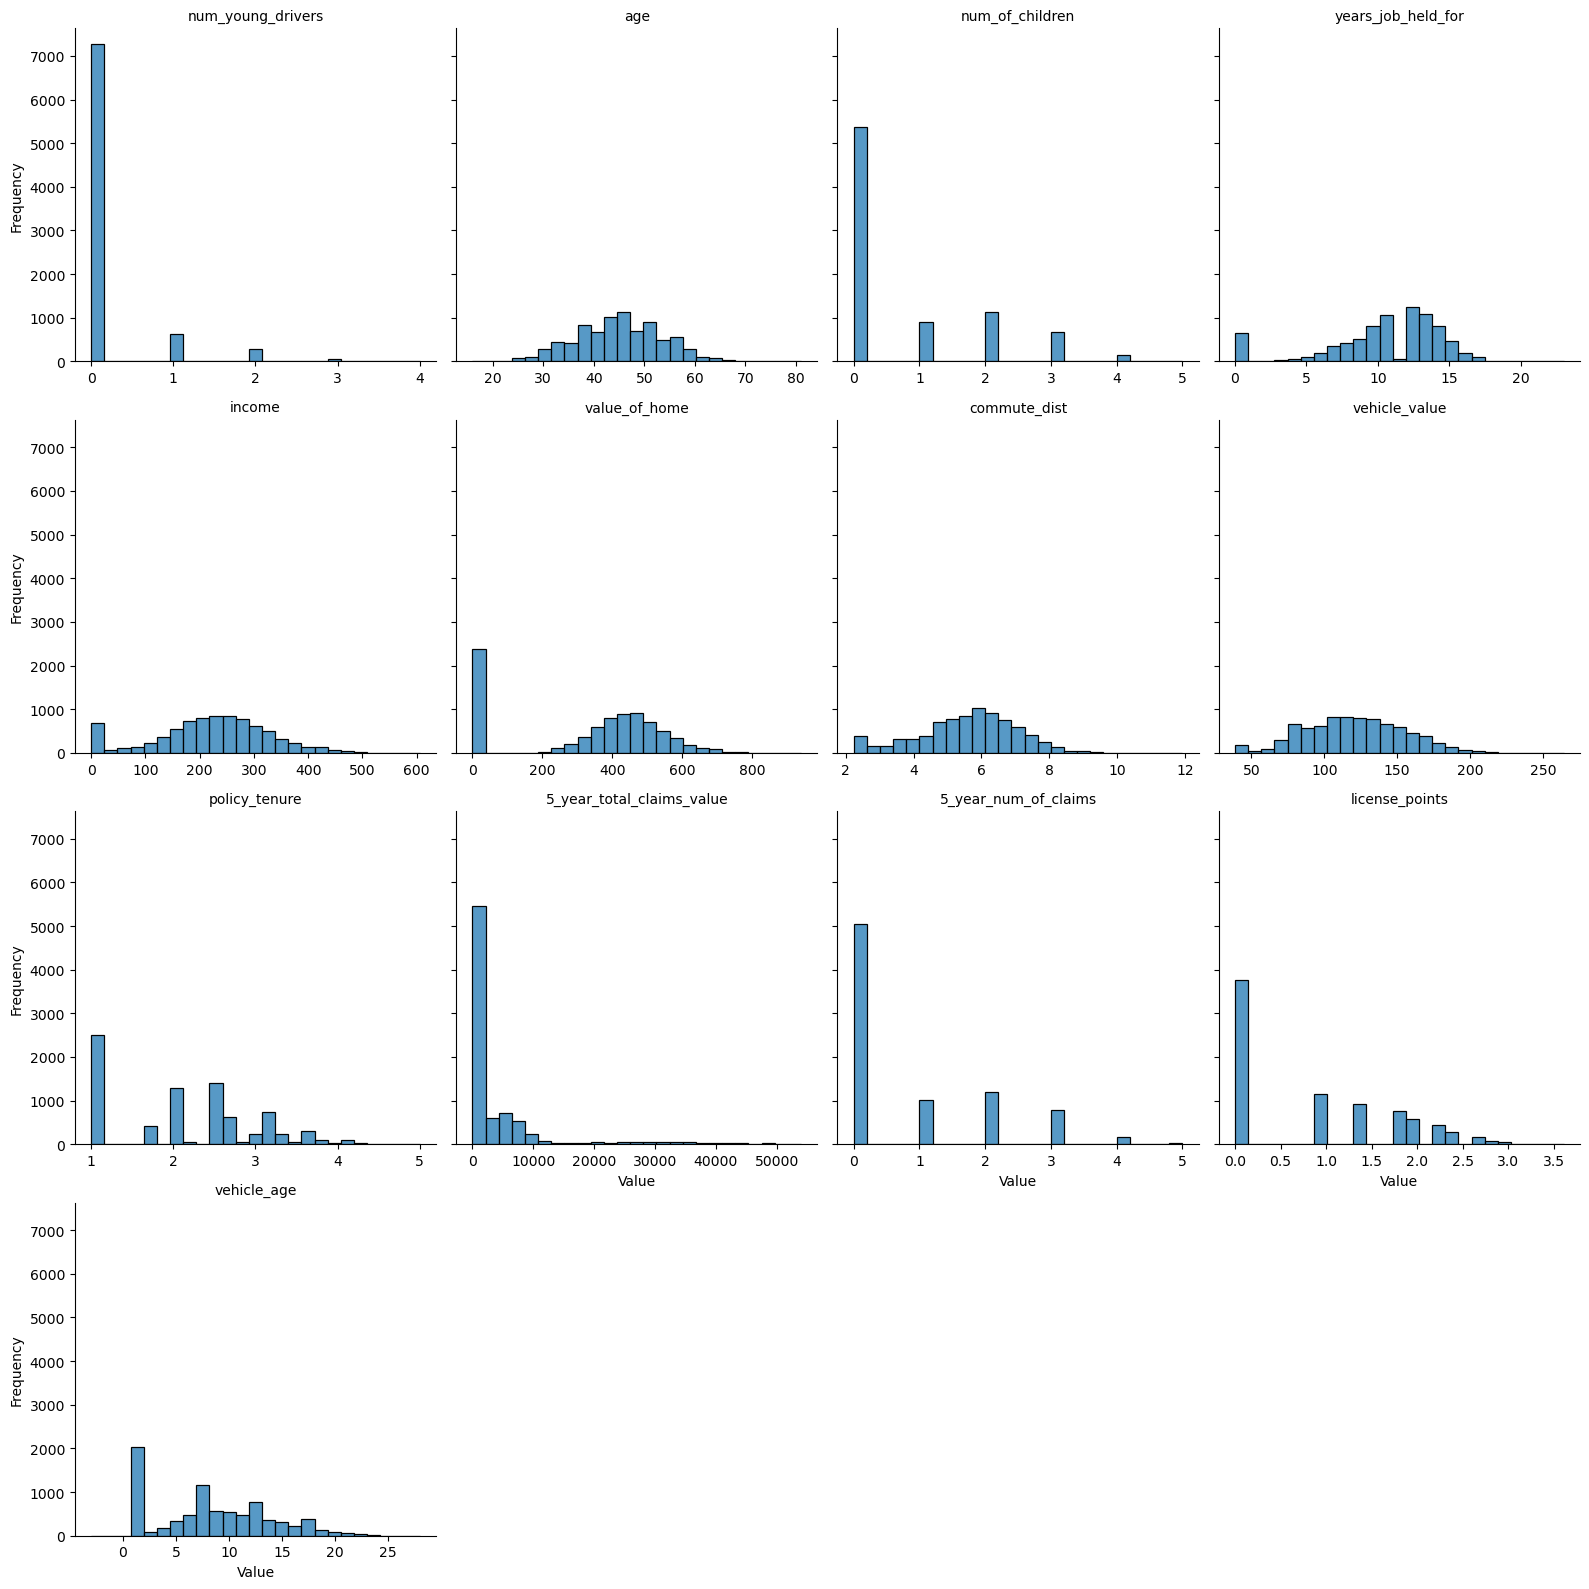

In [67]:
melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name="Column", value_name="Value")
g = sns.FacetGrid(melted_X_train, col="Column", col_wrap=4, sharex=False, height=4)
g.map(sns.histplot, "Value", bins=25)
g.set_axis_labels("Value", "Frequency")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()

The skews have been reduced, so let's now see if it has improved the performance of the XGBoost model.

In [68]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf)

print(f"CV Score without log transform: {cv_scores.mean()}")
print(f"CV Score with log transform: {cv_scores_log.mean()}")

CV Score without log transform: 0.7787621359223302
CV Score with log transform: 0.7787621359223302


It's clear that our log transform made no impact in improving the base score. This is often to be expected with boosting models, as they are less sensitive to skew and scale than some models. However, it may be beneficial to our regression model later so we'll keep it.

Feature Scaling

Now let's check if scaling our numerical features has any impact on model performance.

In [69]:
# scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy()
    # initialize scaler
    scaler = StandardScaler()
    # fit scaler
    scaler.fit(data[numeric_features])
    # transform numeric features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

X_train_cleaned_scaled = scale_features(X_train_cleaned_log, numerical_cols)

In [70]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

print(f"CV score without log transform: {cv_scores.mean()}")
print(f"CV score with log transform: {cv_scores_scaled.mean()}")

CV score without log transform: 0.7787621359223302
CV score with log transform: 0.7787621359223302


Again, it's clear that the scaling made no impact in improving the base score. However, it may be beneficial to our regression model later so we'll keep it.

In [71]:
X_train_cleaned = X_train_cleaned_scaled.copy()

#### 7 Model Pipeline
#### 7.1 Custom Transformers

As we want to drop the unwanted 'red_vehicle' column, we'll create a custom transformer to do this that we can use in our pipeline.

In [72]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

In [73]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

#### 7.2 Pipelines

In [74]:
from sklearn import set_config

# Setting transformer output to df so we can reference columns names
set_config(transform_output="pandas")

In [75]:
# Column droppper pipeline
cols_to_drop =["red_vehicle"]
cols_to_drop_pipeline = Pipeline([
    ("col_dropper", ColumnDropper(cols_to_drop))
])

skewed_features = ["income", "value_of_home", "commute_dist", "vehicle_value", "policy_tenure", "license_points"]

# Numerical fature pipeline
num_pipeline = Pipeline([
    ("knn_imputer", KNNImputer(n_neighbors=2)),
    ("sqrt", SqrtTransformer(skewed_features)),
    ("scaler", StandardScaler())
])


# Rank of education
education_rank = [["<High School", "High School", "Bachelors", "Masters", "PhD"]]

# Ordinal categorical feature pipeline (highest_education feature)
categorical_ord_pipeline = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("ord_encoder", OrdinalEncoder(categories=education_rank))
])

# Binary categorical feature pipeline
categorical_bin_pipeline = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("binary_encoder", OrdinalEncoder())
])

# One hot pipeline
categorical_one_hot_pipeline = Pipeline([
    ("cat_simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"))
])

# Prepocessing pipeline wiht a column transformer
preprocess_pipeline = ColumnTransformer([
    ("drop_features", cols_to_drop_pipeline, cols_to_drop),
    ("num", num_pipeline, numerical_cols),
    ("categorical_ord", categorical_ord_pipeline, categorical_cols_ord),
    ("categorical_bin", categorical_bin_pipeline, categorical_cols_bin),
    ("categorical_one_hot", categorical_one_hot_pipeline, categorical_cols_onehot)
])

Transforming the raw X_train dataset is now possible with this pipeline

In [76]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

We've transformed the test data using our pipeline. We can check the pipeline is correct by checking it against the DataFrame we built manually. We just need to make sure the column names match so we can compare them.

In [77]:
# create df from processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=preprocess_pipeline.get_feature_names_out()
)

# Names of the new one-hot columns
one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(categorical_cols_onehot))

# list of all coumns names
new_col_names = numerical_cols + categorical_cols_ord + categorical_cols_bin + one_hot_col_names

# rename df columns
X_train_prepared_df.columns = new_col_names

# reset index
X_train_prepared_df.reset_index(drop=True, inplace=True)

X_train_prepared_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [78]:
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [79]:
X_train_cleaned.equals(X_train_prepared_df)

True

The output from the pipeline is the same as our manually created DataFrame

#### 8. Hyperparameter Optimisation
##### 8.1 Random Search

In [80]:
# parameters
xgb_param_grid = {
    "n_estimators": randint(low=50, high=300),
    "learning_rate": uniform(0.01, 0.29),
    "max_depth": randint(low=1, high=20),
    "subsample": uniform(0, 1),
    "colsample_bytree": uniform(0, 1),
    "min_child_weight": randint(low=1, high= 20),
    "reg_alpha": randint(low=0, high=100),
    "reg_lambda":randint(low=0, high=10),
    "gamma": uniform(0, 1),   
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric="error")

# RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average="weighted")
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000,
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [81]:
# Fit the model RandomizedSearchCV
random_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters: {}".format(random_search.best_params_))
print("Best Cross-validation score:", random_search.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters: {'colsample_bytree': 0.6273965553158464, 'gamma': 0.2595504332730826, 'learning_rate': 0.09479339691584471, 'max_depth': 18, 'min_child_weight': 18, 'n_estimators': 155, 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 0.9225724049058001}
Best Cross-validation score: 0.7837866251312892


##### 8.2 Grid Search
The grid search is a simple and effective way to find the best hyperparameters for a model.
Now that we have the best parameter values from our Random Search. We can now use grid search to check parameter combinations within the reduced grid space.

In [82]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    "n_estimators": [280, 290, 300],
    "max_depth": [6, 7, 8],
    "learning_rate": [0.03, 0.04, 0.05],
    "subsample": [0.45, 0.5, 0.55],
    "colsample_bytree": [0.5, 0.55, 0.6],
    "gamma": [0.05, 0.1, 0.15],
    "min_child_weight": [18],
    "reg_alpha": [1],
    "reg_lambda": [1],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average="weighted")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [83]:
# fit the model
grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found:", grid_search.best_params_)
print("Best Cross-validation score:", grid_search.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found: {'colsample_bytree': 0.6, 'gamma': 0.15, 'learning_rate': 0.04, 'max_depth': 6, 'min_child_weight': 18, 'n_estimators': 290, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5}
Best Cross-validation score: {'colsample_bytree': 0.6, 'gamma': 0.15, 'learning_rate': 0.04, 'max_depth': 6, 'min_child_weight': 18, 'n_estimators': 290, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5}


In [84]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.7787621359223302
XGBoost model score (tuned hyperparamters: 0.7866771597325684


An improvement of nearly 0.8% is noted

#### 9. Model Evaluation
The model evaluation is the process of assessing the performance of a model.

In [85]:
# test set pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# prediction using the best model
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

In [86]:
# prediction score with f1
f1_score(y_test, y_pred, average="weighted")

0.7749909518772566

Confussion Matrix

Text(0.5, 1.0, 'Confussion Matrix on Training Data')

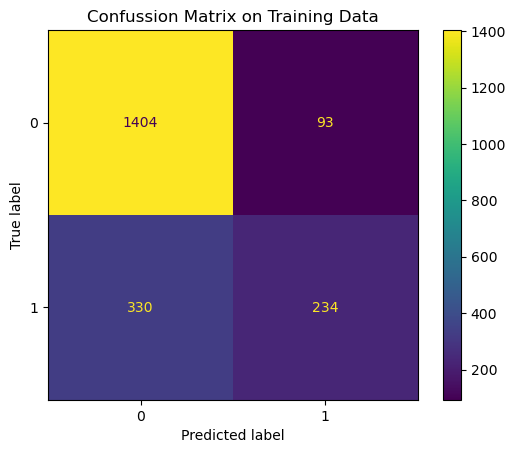

In [87]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confussion Matrix on Training Data")

#### 10. Regression
##### 10.1 Train/Test Sets


We can now proceed to the regression part of this project. Our goal is to predict the total value of a claim, assuming a claim has been made. We begin by creating the test and train sets, using only records where the claim value is greater than zero.

In [88]:
# Return only the rows with value more than 0
claim_data = data_df[data_df["new_claim_value"] > 0]

X_reg = claim_data.copy()
y_reg = claim_data["new_claim_value"]

# Drop the target feature
X_reg.drop(columns=["new_claim_value", "is_claim", "claim_value_cat"], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Using the already created pipeline to preprocess our train set

In [89]:
X_reg_train_prepared = preprocess_pipeline.fit_transform(X_reg_train)

##### 10.2 Model Selection

In [90]:
regs = [
    ("Linear Regression", LinearRegression()),
    ("Logistic Regression", LogisticRegression(random_state=42, max_iter=25, solver="sag", tol=3)),
    ("SGD Regressor", SGDRegressor(random_state=42)),
    ("Decision Tree Regression ", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("KNN Model ", KNeighborsRegressor()),
    ("Support Vector Machines (SVM)", SVR(gamma=2, C=1)),
    ("XGBRegressor", XGBRegressor(random_state=42))
]

Using the RMSE for scoring the models as it's more sensitive to outlier

In [91]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    cv_rmses = -cross_val_score(reg, X_reg_train_prepared, y_reg_train, cv=reg_kf, scoring="neg_root_mean_squared_error")
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

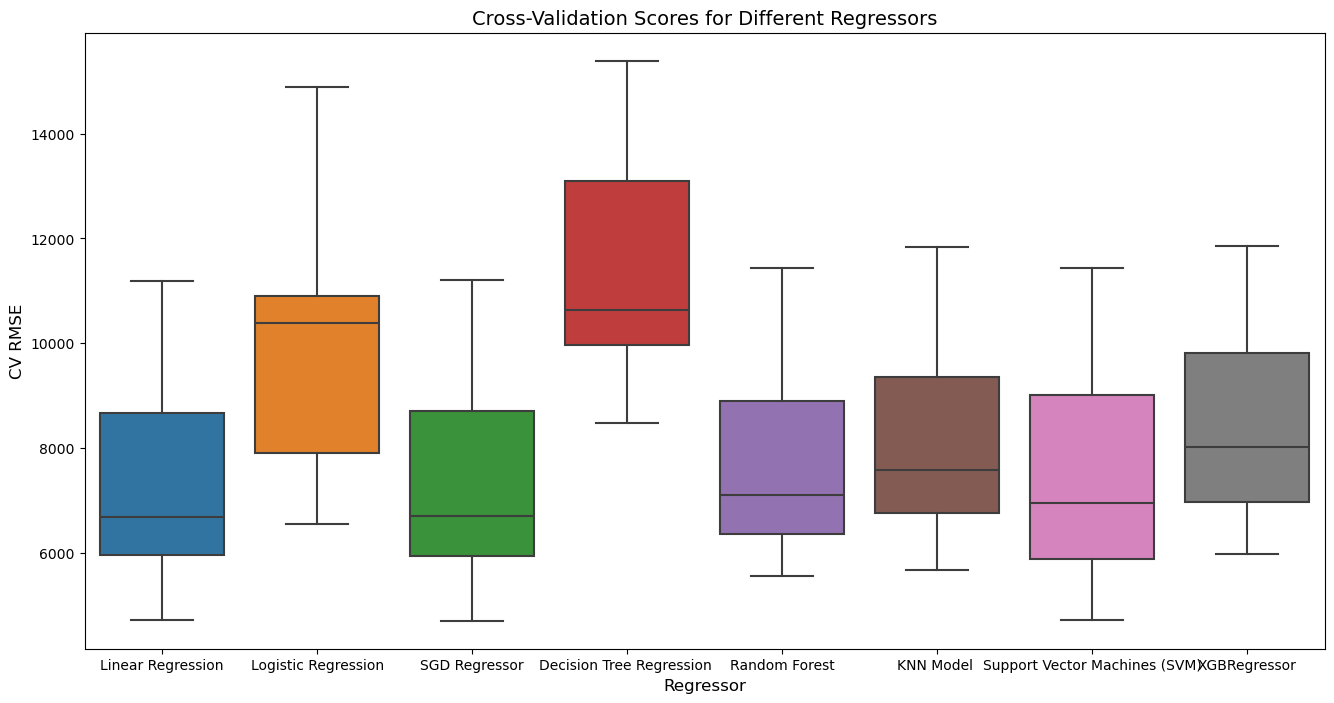

In [92]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel("Regressor", fontsize=12)
ax.set_ylabel("CV RMSE", fontsize=12)
ax.set_title("Cross-Validation Scores for Different Regressors", fontsize=14)


Since we are using RMSE as the scoring method, a lower RMSE indicates better performance. Both the linear regression and SGD regressor models performed the best, with very similar scores, given their similarities. Given the greater flexibility to tune the SGD regressor, we will proceed with it.

##### 10.3 Hyperparameter Optimisation

In [93]:
# Define the parameter grid for SGDRegressor
reg_param_grid = {
    "penalty": ["l2", "l1", "elasticnet"],
    "alpha": uniform(0.0001, 0.01),
    "learning_rate": ["constant", "invscaling"],
    "eta0": uniform(0.001, 0.1),
    "max_iter": randint(100, 1000),
    "tol": uniform(1e-6, 1e-3)
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring="neg_mean_squared_error",
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# # Fit the model using RandomizedSearchCV
# random_search.fit(X_reg_train_prepared, y_reg_train)

# score = np.sqrt(-random_search.best_score_)

# # Print the best parameters and the best score
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation score: ", score)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits

Best parameters found:  
 - alpha: --> 0.008548753109694546, 
 - eta0:   -->  0.003327193573582587, 
 - learning_rate: -->  invscaling, 
 - max_iter:    --> 214, 
 - penalty:     --> l2, 
 - tol:     --> 0.0004970374542934063

Best cross-validation score:  7607.8834880806835


We can now use grid search with the reduce parameter space.

In [95]:
# Define the parameter grid for SGDRegressor
reg_param_grid_gs = {
    "penalty": ["l2", "l1", "elasticnet"],
    "alpha": [0.004, 0.008, 0.012],
    "learning_rate": ["invscaling"],
    "eta0": [0.001, 0.003, 0.005],
    "max_iter": [180, 200, 220],
    "tol": [1e-5, 1e-4, 1e-6]
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_grid_search = GridSearchCV(
    estimator=sgd_regressor,
    param_grid=reg_param_grid_gs,
    scoring="neg_mean_squared_error",
    cv=reg_kf,
    verbose=1,
    n_jobs=-1
)

In [96]:
# Fit the model
reg_grid_search.fit(X_reg_train_prepared, y_reg_train)

reg_score = np.sqrt(-reg_grid_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", reg_grid_search.best_params_)
print("Best cross-validation score: ", reg_score)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best parameters found:  {'alpha': 0.012, 'eta0': 0.003, 'learning_rate': 'invscaling', 'max_iter': 180, 'penalty': 'l2', 'tol': 1e-05}
Best cross-validation score:  7605.2923588743715


No significant imporvement to the model

##### 10.4 Model Evaluation

In [97]:
X_reg_test_prepared = preprocess_pipeline.fit_transform(X_reg_test)

y_reg_pred = reg_grid_search.best_estimator_.predict(X_reg_test_prepared)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_reg_test, y_reg_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 8378.846093356431
MAE: 3556.2627508324217


The RMSE score was slightly higher on the test set compared to the training set, but still within a reasonable range. Similar to the classification model, there is significant room for improvement, such as additional feature engineering, exploring feature importance, or combining multiple models to create an ensemble.

##### Saving the 2 models

In [98]:
import joblib

In [99]:
cls_grid_search_model =  "./data/cls_grid_search_model.pkl"
joblib.dump(grid_search, cls_grid_search_model)

['./data/cls_grid_search_model.pkl']

In [100]:
reg_grid_search_model =  "./data/reg_grid_search_model.pkl"
joblib.dump(reg_grid_search, reg_grid_search_model)

['./data/reg_grid_search_model.pkl']